In [1]:
import os
import random
import numpy as np
import tensorflow as tf 

SEED = 42

# Reproducibilidad Python y NumPy
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Control de Semilla de TensorFlow/Keras
tf.random.set_seed(SEED) 

# 3. Control de hilos
os.environ["TF_INTER_OP_PARALLELISM_THREADS"] = "1"
os.environ["TF_INTRA_OP_PARALLELISM_THREADS"] = "1"

In [2]:
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Embedding, LayerNormalization, Dropout,
    MultiHeadAttention, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate as KConcat
)


In [3]:
# Recuperar el mismo DataFrame
with open('dfe_guardado.pkl', 'rb') as e:
    dfe = pickle.load(e)
dft = dfe.copy()

In [4]:
model = load_model("tabtransformer_best.keras")

with open("label_encoders.pkl", "rb") as f:
    cat_label_encoders = pickle.load(f)

# dft = dft.drop(['goles_local', 'goles_visitante'], axis=1)

In [5]:
cantidad = -5

def generar_features_5_partidos(dft):
#    dft = dft.copy()

    # Crea columna resultado_num para convertir resultado a valores numéricos fáciles de sumar
    res_map = {"LOCAL": 1, "EMPATE": 0, "VISITANTE": -1}
    dft["resultado_num"] = dft["resultado"].map(res_map)

    # Se crean nuevas columnas para almacenas las estadisticas de cada equipo segun su participación local o visitante
    dft["racha_global_local_5"] = 0
    dft["racha_local_5"] = 0
    dft["racha_global_visit_5"] = 0
    dft["racha_visit_5"] = 0
    dft["duelos_directos_local_5"] = 0

    # Inicializar los diccionarios de datos para almacenar la lista de resultados [0,1,-1]
    hist_global = {}
    hist_local = {}    
    hist_visit = {}
    hist_duelos = {}
    
    # Se crea arreglo equipos para tener el total de equipos del dataframe sin tener duplicados dft
    equipos = pd.concat([dft["equipo_local"], dft["equipo_visitante"]]).unique()
    
    # Inicializar el recorrido equipo por equipo diferenciando si fue local o visitante
    for e in equipos:
        hist_global[e] = []
        hist_local[e] = []
        hist_visit[e] = []
        hist_duelos[e] = {}

    # Inicializar el recorrido historial duelos directos
    for e1 in equipos:
        for e2 in equipos:
            if e1 != e2:
                hist_duelos[e1][e2] = []

    # Recorrer el dataframe partido por partido
    for idx, row in dft.iterrows():
        el = row["equipo_local"]
        ev = row["equipo_visitante"]
        result = row["resultado_num"]

        # Se toma el resultado del equipo en sus ultimos 5 partidos y se suman
        dft.at[idx, "racha_global_local_5"] = sum(hist_global[el][cantidad:])
        dft.at[idx, "racha_global_visit_5"] = sum(hist_global[ev][cantidad:])

        # Se toma el resultado del equipo en sus ultimos 5 partidos de local y de visitante y se suman de manera independiente
        dft.at[idx, "racha_local_5"] = sum(hist_local[el][cantidad:])
        dft.at[idx, "racha_visit_5"] = sum(hist_visit[ev][cantidad:])

        # Se suman los últimos 5 duelos directos entre los dos equipos separando quien jugo de local y visitante 
        dft.at[idx, "duelos_directos_local_5"] = sum(hist_duelos[el][ev][cantidad:])

        # Se actualiza el historial para equipo local y visitante
        hist_global[el].append(result)
        hist_global[ev].append(-result)  # inverso para visitante

        hist_local[el].append(result)
        hist_visit[ev].append(-result)

        # Se actualiza el historial para duelos directos
        hist_duelos[el][ev].append(result)      # local
        # hist_duelos[ev][el].append(-result)     # visitante

    return dft, hist_global, hist_local, hist_visit, hist_duelos


In [6]:
# Desempaquetar la tupla
dft, hist_global, hist_local, hist_visit, hist_duelos = generar_features_5_partidos(dft)

In [7]:
# Definir columnas por tipo de datos y objetivo
categorical_cols = ['ronda', 'equipo_local', 'equipo_visitante']  # embeddings
numeric_cols = ['racha_global_local_5', 'racha_local_5','racha_global_visit_5','racha_visit_5',
                'duelos_directos_local_5']
target_col = 'resultado' # valores: 'LOCAL','EMPATE','VISITANTE'

In [8]:
# Codificar la variable objetivo en números para facilitar el procesamiento
le_target = LabelEncoder()
dft['target_enc'] = le_target.fit_transform(dft[target_col])  # 0,1,2 por ejemplo
class_names = le_target.classes_.tolist()  # ['EMPATE','LOCAL','VISITANTE'] orden depende de fit


In [9]:
# Codificar las variables categoricas en numeros para facilitar el procesamiento
cat_label_encoders = {}
for c in categorical_cols:
    le = LabelEncoder()
    dft[c + "_enc"] = le.fit_transform(dft[c].astype(str))
    cat_label_encoders[c] = le


In [10]:
# Asegura que todas las variables numericas aportan de manera equilibrada al entrenar el modelo
scaler_num = StandardScaler()
dft_num = scaler_num.fit_transform(dft[numeric_cols].astype(float))


In [11]:
# Crear el arreglo para entradas categoricas y numericas y preparar los tensores de entrada

X_cat = np.stack([dft[c + "_enc"].values for c in categorical_cols], axis=1) 
X_num = dft_num  # shape (N, num_num)
y = dft['target_enc'].values
num_classes = len(np.unique(y))

In [12]:
Xc_train, Xc_test, Xn_train, Xn_test, y_train, y_test = train_test_split(
    X_cat, X_num, y,
    test_size=0.25,
    random_state=SEED,
    stratify=y
)

In [13]:
# Configuración de hiperparametros y dimesiones clave para construir un transformer Tabtransformer
num_categorical = X_cat.shape[1]      
num_numeric = X_num.shape[1]
embedding_dim = 16  # se selecciona debido a que hay posible 20 a 25 categorias
num_heads = 2
ff_dim = 32   
dropout_rate = 0.2

# Para cada categoria, necesitamos el tamaño
vocab_sizes = [ int(dft[c].nunique()) + 1 for c in categorical_cols ]

In [14]:
# Contrucción del TabTransformer con Keras

cat_inputs = [Input(shape=(1,), dtype='int32', name=f"cat_{c}") for c in categorical_cols]
num_input = Input(shape=(num_numeric,), dtype='float32', name='numerics')

# Embeddings por columna, se concatenan para formar la "secuencia"
embeddings = []
for i, inp in enumerate(cat_inputs):
    vsize = vocab_sizes[i]
    emb = Embedding(input_dim=vsize, output_dim=embedding_dim, name=f"emb_{i}")(inp)  # (batch,1,emb)
    embeddings.append(emb)

# Concatenate embeddings, (batch, seq_len, emb_dim)

seq_emb = KConcat(axis=1)(embeddings)  # shape (batch, num_categorical, embedding_dim)

In [15]:
# Codigo para que el modelo aprenda de forma mas estable y precisa
seq_emb = LayerNormalization()(seq_emb)

# Modelo aprenda relaciones entre variables
attn = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(seq_emb, seq_emb)
attn = LayerNormalization()(attn)
attn = Dropout(dropout_rate)(attn)

# modelo aprenda representaciones profundas
ff = Dense(ff_dim, activation='relu')(attn)
ff = Dropout(dropout_rate)(ff)
ff = LayerNormalization()(ff)

# Genrar vector que representa toda la información de varialbes categoricas
pooled = GlobalMaxPooling1D()(ff) 

# Integrar las caracteristcas del data set en un unico vector
concat = KConcat()([pooled, num_input])

In [16]:
# Head clasificador
x = Dense(32, activation='relu')(concat)
x = Dropout(0.3)(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=cat_inputs + [num_input], outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cat_ronda (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_equipo_local (InputLayer) │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_equipo_visitante          │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ emb_0 (Embedding)             │ (None, 1, 16)             │              64 │ cat_ronda[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ emb_1 (Embedding)             │ (None, 1, 16)             │             416 │ cat_equipo_local[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ emb_2 (Embedding)             │ (None, 1, 16)             │             416 │ cat_equipo_visitante[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 3, 16)             │               0 │ emb_0[0][0], emb_1[0][0],  │
│                               │                           │                 │ emb_2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 3, 16)             │              32 │ concatenate[0][0]          │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 3, 16)             │           2,160 │ layer_normalization[0][0], │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 3, 16)             │              32 │ multi_head_attention[0][0] │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 3, 16)             │               0 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 3, 32)             │             544 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 3, 32)             │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 3, 32)             │              64 │ dropout_3[0][0]            │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,523 (21.57 KB)

 Trainable params: 5,523 (21.57 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Preparar datos para Keras (inputs por tensor)

def build_model_inputs(Xc, Xn):
    # Xc shape (N, num_cat), Xn shape (N, num_num)
    inputs = {}
    for i, c in enumerate(categorical_cols):
        inputs[f"cat_{c}"] = Xc[:, i]
    inputs['numerics'] = Xn
    return inputs

train_inputs = build_model_inputs(Xc_train, Xn_train)
test_inputs = build_model_inputs(Xc_test, Xn_test)


In [18]:
class_weight_dict = {
    0: 1.20,   # EMPATE
    1: 1,   # LOCAL
    2: 1.50    # VISITANTE
}

print("Pesos usados:", class_weight_dict)

Pesos usados: {0: 1.2, 1: 1, 2: 1.5}


In [19]:
# Crear conjunto de validación a partir del train
Xc_train, Xc_val, Xn_train, Xn_val, y_train, y_val = train_test_split(
    Xc_train, Xn_train, y_train,
    test_size=0.15,
    random_state=SEED,
    shuffle=True,
    stratify=y_train
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint_path = "tabtransformer_best.keras"
mc = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)


# Preparar inputs para el modelo (listas de arrays categóricos + numéricos)
train_inputs = [Xc_train[:, i] for i in range(Xc_train.shape[1])] + [Xn_train]
val_inputs   = [Xc_val[:, i]   for i in range(Xc_val.shape[1])]   + [Xn_val]
test_inputs  = [Xc_test[:, i]  for i in range(Xc_test.shape[1])]  + [Xn_test]

# Ahora puedes entrenar con train/val y dejar test solo para evaluación final:
history = model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es, mc, lr_scheduler],
    class_weight=class_weight_dict,
    shuffle=False, 
    verbose=1
)

# Evaluación final en test
test_loss, test_acc = model.evaluate(test_inputs, y_test, verbose=0)
print(f"Rendimiento en test -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

Epoch 1/100
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3220 - loss: 1.5414  
Epoch 1: val_loss improved from None to 1.11466, saving model to tabtransformer_best.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.3386 - loss: 1.4569 - val_accuracy: 0.3360 - val_loss: 1.1147 - learning_rate: 0.0010
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3722 - loss: 1.3414 
Epoch 2: val_loss improved from 1.11466 to 1.08177, saving model to tabtransformer_best.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3980 - loss: 1.3216 - val_accuracy: 0.4575 - val_loss: 1.0818 - learning_rate: 0.0010
Epoch 3/100
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3904 - loss: 1.3339 
Epoch 3: val_loss did not improve from 1.08177
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4059 - loss: 1.3053 - val_accuracy: 0.3644 - val_loss: 1.0945 - learning_rate: 0.0010
Epoch 4/100
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4154 - loss: 1.2972 

In [20]:
model.save("tabtransformer_best.keras")

with open("label_encoders.pkl", "wb") as f:
    pickle.dump(cat_label_encoders, f)
    
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler_num, f)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step  
Accuracy (test): 0.4408014571948998

Classification report:
               precision    recall  f1-score   support

      EMPATE       0.34      0.19      0.25       165
       LOCAL       0.50      0.65      0.57       251
   VISITANTE       0.36      0.36      0.36       133

    accuracy                           0.44       549
   macro avg       0.40      0.40      0.39       549
weighted avg       0.42      0.44      0.42       549

F1 macro: 0.39116322274217014
F1 micro: 0.4408014571948998

Confusion matrix:
 [[ 32  96  37]
 [ 41 162  48]
 [ 22  63  48]]


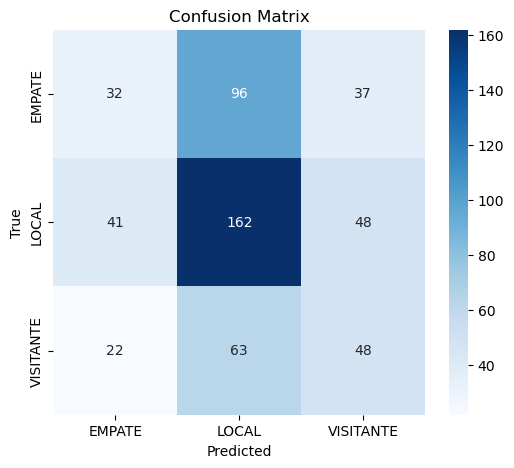

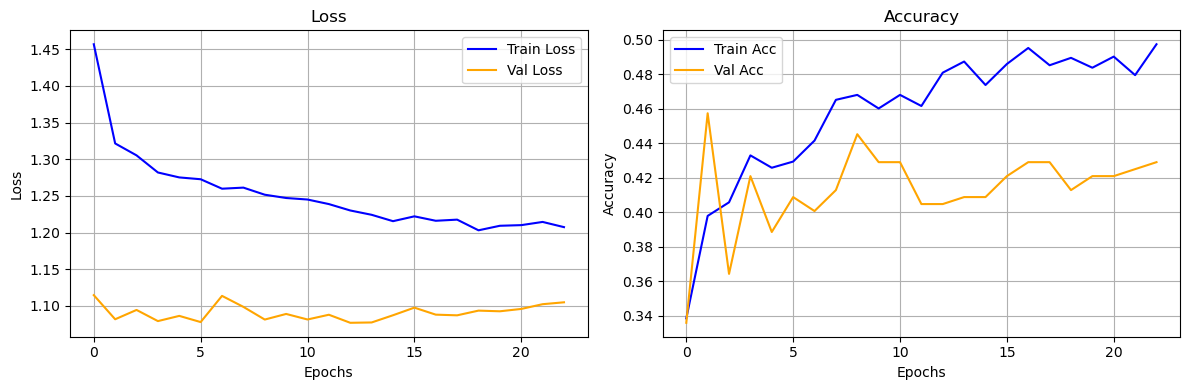

In [21]:
# Metricas y evaluación del modelo, Predicciones
y_pred_proba = model.predict(test_inputs)
y_pred = np.argmax(y_pred_proba, axis=1)

# Accuracy
print("Accuracy (test):", accuracy_score(y_test, y_pred))

# Reporte de clasificación
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=class_names))

# F1-score global
print("F1 macro:", f1_score(y_test, y_pred, average='macro'))
print("F1 micro:", f1_score(y_test, y_pred, average='micro'))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n", cm)

# Visualización de la matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Graficar curvas de entrenamiento

plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Acc', color='orange')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
# Lista de equipos únicos en el dataset
equipos_validos = set(dft["equipo_local"].unique()).union(set(dft["equipo_visitante"].unique()))

# Validar entradas
local = "tolima"
visitante = "junior"

if local not in equipos_validos:
    raise ValueError(f"⚠️ Equipo local '{local}' no está en la tabla de equipos.")
if visitante not in equipos_validos:
    raise ValueError(f"⚠️ Equipo visitante '{visitante}' no está en la tabla de equipos.")

print("Ambos equipos son válidos y están en la tabla.")


✅ Ambos equipos son válidos y están en la tabla.


In [23]:
# Generar duelos directos
duelos = dft[
    (dft["equipo_local"] == local) & 
    (dft["equipo_visitante"] == visitante)
].sort_values(
    by=["torneo", "semestre", "ronda","fecha_torneo"],
    ascending=[False, False, False, False]
).head(cantidad*-1)

# Mostrar tabla con estilo
cols = ["torneo", "semestre","ronda", "equipo_local", "equipo_visitante", "goles_local", "goles_visitante", "resultado", "resultado_num"]
display(duelos[cols].style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white')]}]
).set_properties(**{'text-align': 'center'}))

ultimos_duelos_local = hist_duelos[local][visitante][cantidad:]

print(f"Últimos 5 duelos de {local} como local contra {visitante}: {ultimos_duelos_local}")
print("Sumatoria (racha últimos 5 duelos):", sum(ultimos_duelos_local))


,torneo,semestre,ronda,equipo_local,equipo_visitante,goles_local,goles_visitante,resultado,resultado_num
1880,2025,1,INICIAL,tolima,junior,0,0,EMPATE,0
1967,2025,1,CUADRANGULARES,tolima,junior,2,0,LOCAL,1
1595,2024,2,INICIAL,tolima,junior,0,1,VISITANTE,-1
1740,2024,2,CUADRANGULARES,tolima,junior,1,0,LOCAL,1
1290,2023,2,CUADRANGULARES,tolima,junior,3,1,LOCAL,1


Últimos 5 duelos de tolima como local contra junior: [1, -1, 1, 0, 1]
Sumatoria (racha últimos 5 duelos): 2


In [24]:
# Revisar los ultimos duelos local
duelos = dft[
    (dft["equipo_local"] == local)
].sort_values(
    by=["torneo", "semestre", "ronda","fecha_torneo"],
    ascending=[False, False, False, False]
).head(cantidad*-1)

# Mostrar tabla con estilo
cols = ["torneo", "semestre","ronda", "fecha_torneo", "equipo_local", "equipo_visitante", "goles_local", "goles_visitante", "resultado", "resultado_num"]
display(duelos[cols].style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white')]}]
).set_properties(**{'text-align': 'center'}))


ultimos_duelos_local = hist_local[local][cantidad:]

print(f"Historial {local} como local: {ultimos_duelos_local}")
print("Sumatoria (racha últimos 5 duelos):",sum(ultimos_duelos_local))


,torneo,semestre,ronda,fecha_torneo,equipo_local,equipo_visitante,goles_local,goles_visitante,resultado,resultado_num
2154,2025,2,INICIAL,19,tolima,llaneros,3,1,LOCAL,1
2140,2025,2,INICIAL,17,tolima,cali,2,1,LOCAL,1
2113,2025,2,INICIAL,15,tolima,envigado,1,2,VISITANTE,-1
2097,2025,2,INICIAL,13,tolima,medellin,2,3,VISITANTE,-1
2082,2025,2,INICIAL,11,tolima,boyaca chico,4,0,LOCAL,1


Historial tolima como local: [-1, 1, 1, 0, 1]
Sumatoria (racha últimos 5 duelos): 2


In [25]:
# Revisar los ultimos duelos visitante
duelos = dft[
    (dft["equipo_visitante"] == visitante)
].sort_values(
    by=["torneo", "semestre", "ronda","fecha_torneo"],
    ascending=[False, False, False, False]
).head(cantidad*-1)

# Mostrar tabla con estilo
cols = ["torneo", "semestre","ronda", "fecha_torneo" ,"equipo_local", "equipo_visitante", "goles_local", "goles_visitante", "resultado", "resultado_num"]
display(duelos[cols].style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white')]}]
).set_properties(**{'text-align': 'center'}))


ultimos_duelos_visit = hist_visit[visitante][cantidad:]

print(f"Historial {visitante} como Visitante: {ultimos_duelos_visit}")
print("Sumatoria (racha últimos 5 duelos):",sum(ultimos_duelos_visit))

,torneo,semestre,ronda,fecha_torneo,equipo_local,equipo_visitante,goles_local,goles_visitante,resultado,resultado_num
2159,2025,2,INICIAL,19,fortaleza,junior,1,1,EMPATE,0
2134,2025,2,INICIAL,17,america,junior,2,1,LOCAL,1
2119,2025,2,INICIAL,15,alianza petrolera,junior,0,1,VISITANTE,-1
2091,2025,2,INICIAL,12,medellin,junior,2,2,EMPATE,0
2067,2025,2,INICIAL,10,union magdalena,junior,3,1,LOCAL,1


Historial junior como Visitante: [1, -1, 0, 0, 0]
Sumatoria (racha últimos 5 duelos): 0


In [26]:
# Revisar los ultimos duelos global local
duelos = dft[
    (dft["equipo_local"] == local) | 
    (dft["equipo_visitante"] == local)
].sort_values(
    by=["torneo", "semestre", "ronda","fecha_torneo"],
    ascending=[False, False, False, False]
).head(cantidad*-1)

# Mostrar tabla con estilo
cols = ["torneo", "semestre","ronda", "fecha_torneo", "equipo_local", "equipo_visitante", "goles_local", "goles_visitante", "resultado", "resultado_num"]
display(duelos[cols].style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white')]}]
).set_properties(**{'text-align': 'center'}))


ultimos_duelos_global = hist_global[local][cantidad:]

print(f"Historial {local} global: {ultimos_duelos_global}")
print("Sumatoria (racha últimos 5 duelos):",sum(ultimos_duelos_global))

,torneo,semestre,ronda,fecha_torneo,equipo_local,equipo_visitante,goles_local,goles_visitante,resultado,resultado_num
2165,2025,2,INICIAL,20,aguilas doradas,tolima,1,2,VISITANTE,-1
2154,2025,2,INICIAL,19,tolima,llaneros,3,1,LOCAL,1
2151,2025,2,INICIAL,18,union magdalena,tolima,0,2,VISITANTE,-1
2140,2025,2,INICIAL,17,tolima,cali,2,1,LOCAL,1
2127,2025,2,INICIAL,16,equidad,tolima,0,2,VISITANTE,-1


Historial tolima global: [1, 0, 1, 1, 0]
Sumatoria (racha últimos 5 duelos): 3


In [27]:
# Revisar los ultimos duelos global visitante
duelos = dft[
    (dft["equipo_local"] == visitante) | 
    (dft["equipo_visitante"] == visitante)
].sort_values(
    by=["torneo", "semestre", "ronda","fecha_torneo"],
    ascending=[False, False, False, False]
).head(cantidad*-1)

# Mostrar tabla con estilo
cols = ["torneo", "semestre","ronda", "fecha_torneo", "equipo_local", "equipo_visitante", "goles_local", "goles_visitante", "resultado", "resultado_num"]
display(duelos[cols].style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white')]}]
).set_properties(**{'text-align': 'center'}))


ultimos_duelos_global = hist_global[visitante][cantidad:]

print(f"Historial {visitante} global: {ultimos_duelos_global}")
print("Sumatoria (racha últimos 5 duelos):",sum(ultimos_duelos_global))

,torneo,semestre,ronda,fecha_torneo,equipo_local,equipo_visitante,goles_local,goles_visitante,resultado,resultado_num
2172,2025,2,INICIAL,20,junior,nacional,2,1,LOCAL,1
2159,2025,2,INICIAL,19,fortaleza,junior,1,1,EMPATE,0
2150,2025,2,INICIAL,18,junior,santa fe,1,2,VISITANTE,-1
2134,2025,2,INICIAL,17,america,junior,2,1,LOCAL,1
2130,2025,2,INICIAL,16,junior,pereira,3,2,LOCAL,1


Historial junior global: [1, 0, 0, 1, 1]
Sumatoria (racha últimos 5 duelos): 3


In [28]:
def predecir_partido_explicado(model, equipo_local, equipo_visitante, ronda, dft, scaler):
    """
    Predice el resultado usando el modelo pre-entrenado y aplicando las transformaciones correctas.
    """
    # Copiar y ordenar para asegurar que tomamos los ultimos partidos reales
    historial = dft.copy()
    
    orden_ronda = {"INICIAL": 1, "CUADRANGULARES": 2, "FINAL": 3}
    # Si la columna orden_ronda no existe, la creamos, si existe la usamos
    if "orden_ronda" not in historial.columns:
        historial["orden_ronda"] = historial["ronda"].map(orden_ronda).fillna(0)

    historial = historial.sort_values(by=["torneo", "semestre", "orden_ronda"], ascending=True)

    # Calcular los Features (Filtros)
    
    ult5_global_local = historial[(historial["equipo_local"] == equipo_local) | (historial["equipo_visitante"] == equipo_local)].tail(5)    
    val_racha_global_local = 0    
    for _, row in ult5_global_local.iterrows():
        if row['equipo_local'] == equipo_local:
            val_racha_global_local += row['resultado_num'] # 1 gana, -1 pierde
        else: # es visitante
            val_racha_global_local += (row['resultado_num'] * -1) # Invertir resultado

    
    ult5_local = historial[historial["equipo_local"] == equipo_local].tail(5)
    val_racha_local = ult5_local["resultado_num"].sum()

    # Racha Global Visitante
    ult5_global_visit = historial[(historial["equipo_local"] == equipo_visitante) | (historial["equipo_visitante"] == equipo_visitante)].tail(5)
    val_racha_global_visit = 0
    for _, row in ult5_global_visit.iterrows():
        if row['equipo_local'] == equipo_visitante:
            val_racha_global_visit += row['resultado_num']
        else: # es visitante
            val_racha_global_visit += (row['resultado_num'] * -1)

    # Racha Visitante (Últimos 5 partidos DEL visitante JUGANDO de visitante)
    ult5_visit = historial[historial["equipo_visitante"] == equipo_visitante].tail(5)
    val_racha_visit = ult5_visit["resultado_num"].sum() * -1

    # Duelos directos (Local siendo Local vs Visitante siendo Visitante)
    ult5_duelos = historial[
        (historial["equipo_local"] == equipo_local) & 
        (historial["equipo_visitante"] == equipo_visitante)
    ].tail(5)
    val_duelos = ult5_duelos["resultado_num"].sum()

    # 3. Construcción del array numérico crudo
      
    raw_numerics = np.array([[
        val_racha_global_local,
        val_racha_local,
        val_racha_global_visit,
        val_racha_visit,
        val_duelos
    ]])

    # ESCALAR LOS DATOS 

    numeric_cols = [
        "racha_global_local_5",
        "racha_local_5",
        "racha_global_visit_5",
        "racha_visit_5",
        "duelos_directos_local_5"
    ]

    # convertir a DataFrame para evitar warnings
    df_raw = pd.DataFrame(raw_numerics, columns=numeric_cols)
    
    processed_numerics = scaler.transform(df_raw)

    # Preparar inputs categóricos
    input_dict = {
        'cat_equipo_local': cat_label_encoders['equipo_local'].transform([equipo_local]),
        'cat_equipo_visitante': cat_label_encoders['equipo_visitante'].transform([equipo_visitante]),
        'cat_ronda': cat_label_encoders['ronda'].transform([ronda]),
        'numerics': processed_numerics # Usamos el escalado
    }

    # Predicción
    proba = model.predict(input_dict, verbose=0)
    pred_class = np.argmax(proba, axis=1)[0]

    # Mostrar resultados
    print(f"\n🔹 Partido: {equipo_local} vs {equipo_visitante} | Ronda: {ronda}")
    print(f"Stats Calculados (Normalizados): {processed_numerics}")
    print("Resultado probable:", class_names[pred_class])
    
    print("\nProbabilidades:")
    for i, cname in enumerate(class_names):
        print(f"{cname}: {proba[0][i]*100:.2f}%")

    plt.figure(figsize=(6,4))
    plt.bar(class_names, proba[0]*100, color=['skyblue','lightgreen','salmon'])
    plt.title(f"Probabilidades: {equipo_local} vs {equipo_visitante}")
    plt.ylabel("Probabilidad (%)")
    plt.ylim(0,100)
    for i, p in enumerate(proba[0]*100
                         ):
        plt.text(i, p+1, f"{p:.2f}%", ha='center')
    plt.show()

    return pred_class, proba


🔹 Partido: tolima vs junior | Ronda: INICIAL
Stats Calculados (Normalizados): [[1.59859211 0.50278837 1.44315205 0.5251254  1.25218125]]
Resultado probable: LOCAL

Probabilidades:
EMPATE: 29.35%
LOCAL: 50.15%
VISITANTE: 20.50%


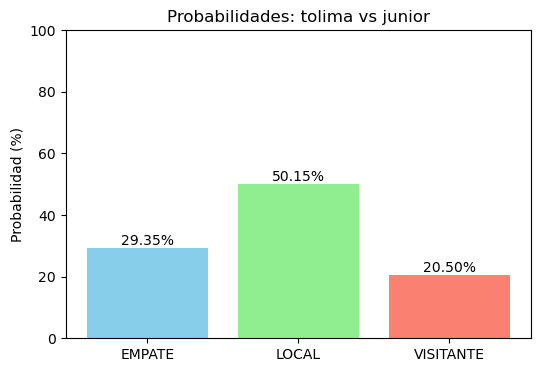

In [29]:
pred_class, proba = predecir_partido_explicado(model, local, visitante, "INICIAL", dft, scaler_num)

#### 